In [19]:
from layers.deformation_layer import NeuralFlowDeformer
from importlib import reload
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

# reload(deflayer)

## 2D conformal mapping experiment

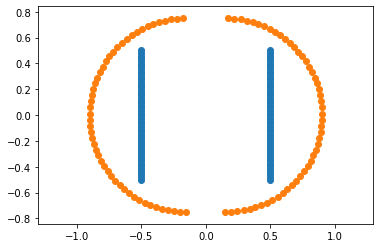

In [20]:
# Helper fn to create geometry
def get_src_tgt():  # lines -> curves
    interp = np.linspace(0, 1, 50)
    src_left = np.array([-.5, -.5]) + interp[:, None] * (np.array([0., 1.]))
    src_rite = np.array([.5, -.5]) + interp[:, None] * (np.array([0., 1.]))
    src = np.concatenate([src_rite, src_left[::-1, :]], axis=0)
    
    angles = np.linspace(-0.5*np.pi, 1.5*np.pi, 100)
    tgt = np.stack([np.cos(angles), np.sin(angles)], axis=-1) * 0.75
    tgt[:50, 0] += 0.15
    tgt[50:, 0] -= 0.15
    return src, tgt

v0, v1 = get_src_tgt()
plt.scatter(v0[:, 0], v0[:, 1])
plt.scatter(v1[:, 0], v1[:, 1])
plt.axis('equal')
plt.show()

In [23]:
# deform src to target with conformal deformer

device = torch.device('cuda')

deformer = NeuralFlowDeformer(dim=2, f_nlayers=6, f_width=100, s_nlayers=2, s_width=1, method='dopri5', conformal=True, nonlinearity='elu', device=device)  # dopri5
optimizer = optim.Adam(deformer.parameters, lr=3e-4)
crit = torch.nn.MSELoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=200)

src, tgt = get_src_tgt()

niter = 1000

GV1 = torch.tensor(src, dtype=torch.float32).unsqueeze(0).to(device)
GV2 = torch.tensor(tgt, dtype=torch.float32).unsqueeze(0).to(device)
GV1_latent = torch.ones([1, 1], dtype=torch.float32).to(device)
GV2_latent = -GV1_latent.clone()
loss_min = 1e30

for it in range(0, niter):
    optimizer.zero_grad()
    
    GV1_deformed = deformer.forward(GV1_latent, GV2_latent, GV1)
    GV2_deformed = deformer.inverse(GV1_latent, GV2_latent, GV2)
    
    loss1 = crit(GV1_deformed, GV2)
    loss2 = crit(GV2_deformed, GV1)

    loss = loss1 + loss2

    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    if it % 100 == 0 or False:
        print('iter=%d, loss1=%.6f loss2=%.6f loss_sum=%.6f'
            %(it, loss1.item(), loss2.item(), loss.item()))


iter=0, loss1=0.064680 loss2=0.064679 loss_sum=0.129359
iter=100, loss1=0.054945 loss2=0.052761 loss_sum=0.107706
iter=200, loss1=0.047146 loss2=0.036384 loss_sum=0.083530
iter=300, loss1=0.032184 loss2=0.027862 loss_sum=0.060046
iter=400, loss1=0.043381 loss2=0.035869 loss_sum=0.079249
iter=500, loss1=0.053892 loss2=0.043412 loss_sum=0.097304
iter=600, loss1=0.054495 loss2=0.043902 loss_sum=0.098397
iter=700, loss1=0.054341 loss2=0.043803 loss_sum=0.098143
iter=800, loss1=0.054328 loss2=0.043796 loss_sum=0.098125
iter=900, loss1=0.054321 loss2=0.043792 loss_sum=0.098114


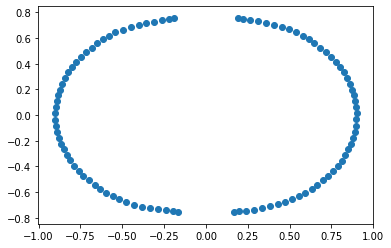

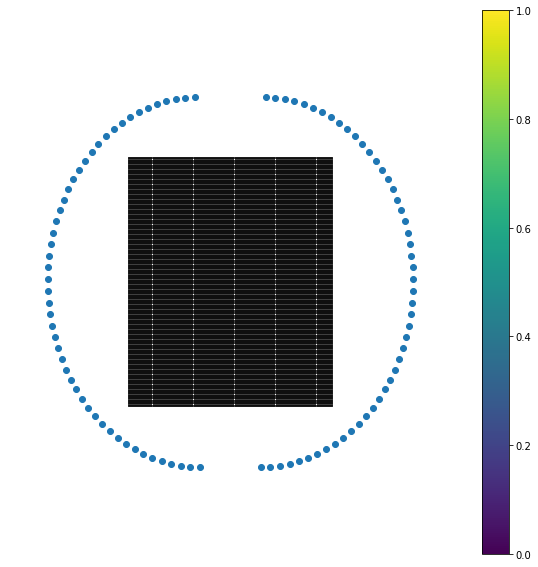

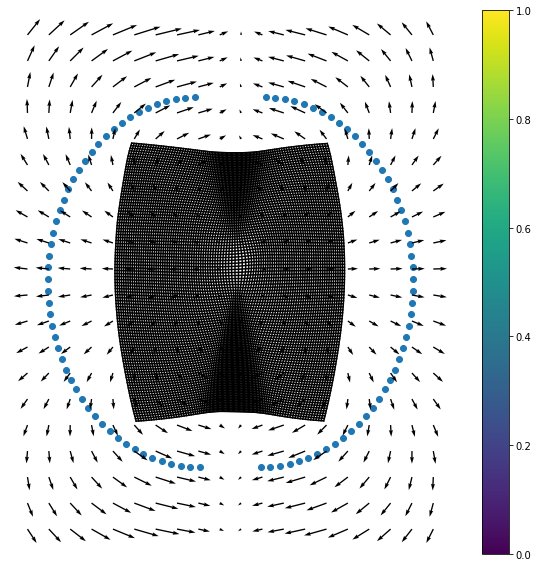

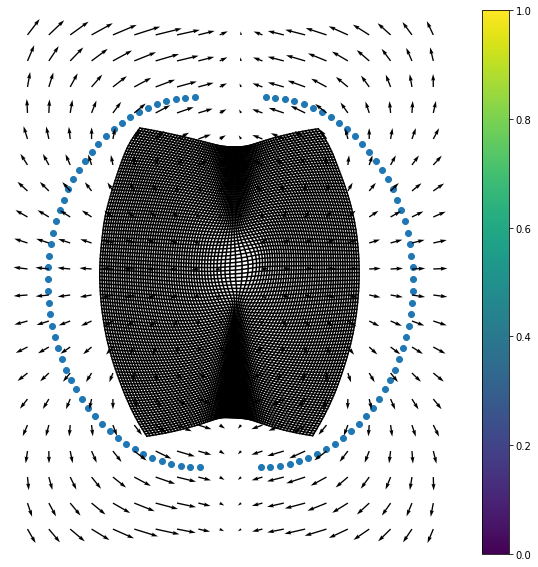

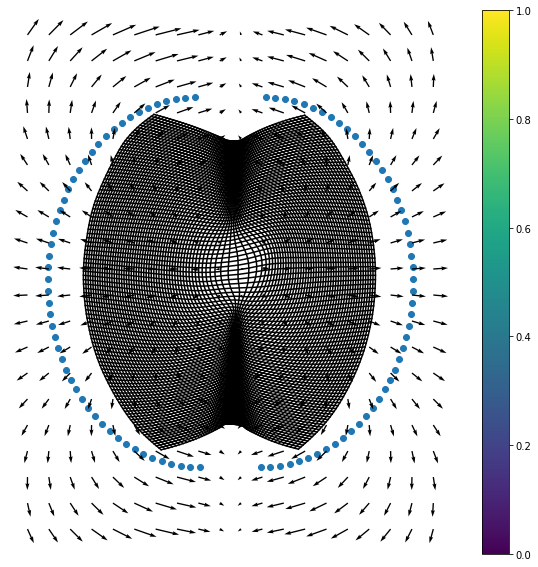

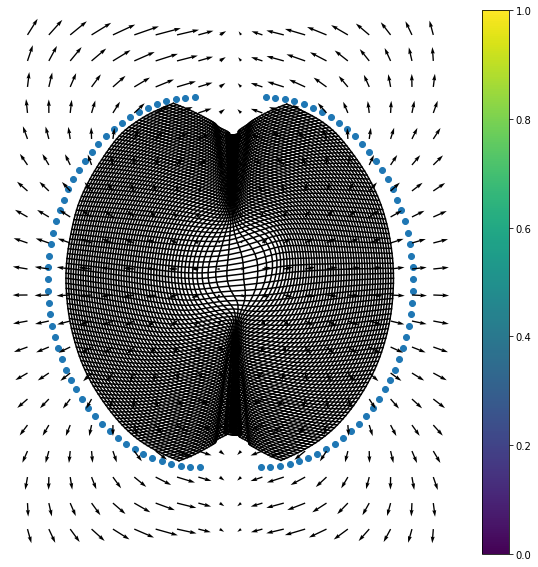

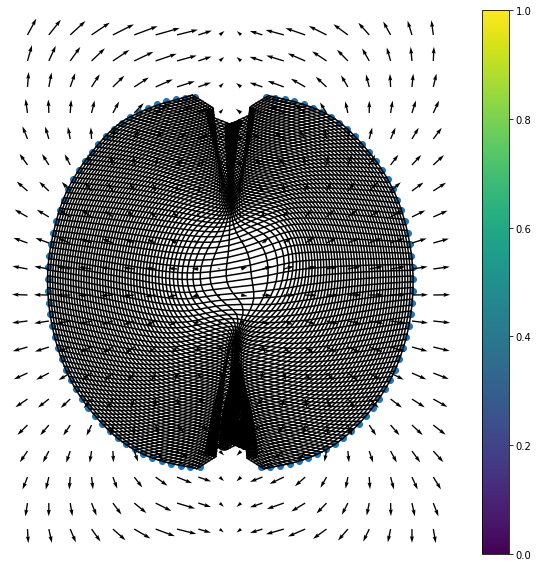

In [22]:
def transform1_2(v1, alpha=1):
    V1 = torch.tensor(v1, dtype=torch.float32).unsqueeze(0).to(device)
    target_latent = GV1_latent + alpha * (GV2_latent - GV1_latent)
    deformer.net.flow_net.output_scalar = False
    V1_deformed = deformer.forward(GV1_latent, target_latent, V1)
    return V1_deformed.squeeze(0).detach().cpu().numpy()

def transform2_1(v2):
    V2 = torch.tensor(v2, dtype=torch.float32).unsqueeze(0).to(device)
    V2_deformed = deformer.forward(GV2_latent, GV1_latent, V2)
    return V2_deformed.squeeze(0).detach().cpu().numpy()
    
def plot_pts(pts):
    plt.scatter(pts[:, 0], pts[:, 1])

    
def plot_vector_field(deformer, res=20, alpha=0.):
    vec = np.stack(np.meshgrid(np.linspace(-1., 1., res), np.linspace(-1., 1., res)), axis=-1).reshape([1, -1, 2])
    vec = torch.tensor(vec, dtype=torch.float32).cuda()
    lat_src = -torch.ones([1, 1], dtype=torch.float32).cuda()
    lat_tgt = torch.ones([1, 1], dtype=torch.float32).cuda()
    lat = lat_src + alpha * (lat_tgt - lat_src)
    if deformer.conformal == True:
#         deformer.net.flow_net.output_scalar = True
#         vel, phi = deformer.net.flow_net(lat, vec)
        vel = deformer.net(alpha, vec)
#         sign = deformer.net.sign_net(lat_src-lat_tgt)
#         phi = phi.reshape([res, res]).detach().cpu().numpy()
#         phi *= sign
    else:
#         vel = deformer.net.flow_net(lat, vec)
#         sign = deformer.net.sign_net(lat_src-lat_tgt)
        vel = deformer.net(alpha, vec)
#     print(sign)
#     vel *= sign
    vel = vel.reshape([res**2, 2]).detach().cpu().numpy()
    vec = vec.reshape([res**2, 2]).detach().cpu().numpy()
#     vec_ = (vec+1)/2*res
    vec_ = vec
    plt.quiver(vec_[:, 0], vec_[:, 1], vel[:, 0], vel[:, 1])
#     if deformer.conformal == True: plt.imshow(phi, origin='lower')
    plt.axis('off')
    plt.colorbar()
    plt.show()    
    
def plot_deformed_grid(grid, v2, alpha):
    s = grid.shape
    grid = grid.reshape([-1, 2])
    grid_trans = transform1_2(grid, alpha=alpha).reshape(s)
    plt.figure(figsize=(10, 10))
    plot_pts(v2)
#     plot grids
    for i in range(s[0]):
        plt.plot(grid_trans[i, :, 0], grid_trans[i, :, 1], c='k')
        plt.plot(grid_trans[:, i, 0], grid_trans[:, i, 1], c='k')
    plot_vector_field(deformer, alpha=alpha)
#     plt.xlim([-.9, .9])
#     plt.ylim([-.9, .9])
    plt.show()

v1 = src
v2 = tgt
v12 = transform1_2(v1)
v21 = transform2_1(v2)
grid = np.stack(np.meshgrid(np.linspace(-.5, .5, 100), np.linspace(-.5, .5, 100)), axis=-1)

plot_pts(v12)

for a in np.linspace(0, 1, 6):
    plot_deformed_grid(grid, v2, alpha=a)

In [ ]:
# net = deflayer.ConformalDeformationFlowNetwork(dim=2, nonlinearity='softplus')
# lat0 = torch.tensor([[-1.]], dtype=torch.float32).to(device)
# lat1 = torch.tensor([[1.]], dtype=torch.float32).to(device)
# res = 20
# vec = torch.stack(torch.meshgrid(torch.linspace(-1, 1, res), torch.linspace(-1, 1, res)), axis=-1).reshape([1, -1, 2])
# # vel, phi = net(lat, vec)
# vel = net(lat, vec)

# vel = vel.reshape([res**2, 2]).detach().cpu().numpy()
# # phi = phi.reshape([res, res]).detach().cpu().numpy()
# vec = vec.reshape([res**2, 2]).detach().cpu().numpy()

# import matplotlib.pyplot as plt
# %matplotlib inline
# vec_ = (vec+1)/2*res
# plt.figure(figsize=(10, 10))
# plt.quiver(vec_[:, 0], vec_[:, 1], vel[:, 0], vel[:, 1])
# # plt.imshow(phi.T, origin='lower')
# # plt.colorbar()
# plt.show()